## Import Libraries
The code used to implement the TD3 agent is taken from here: https://github.com/higgsfield/RL-Adventure-2.

In [1]:
import math
import random
import time
import pandas as pd

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

## Save gifs of agent

In [2]:
def save_frames_as_gif(frames, path='./Visualizations/', filename='pendulum_gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps= 120)

## Create log(cosh) loss

In [3]:
def log_cosh(x):
    return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)

def log_cosh_loss(y_pred, y_true):
    return torch.mean(log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return log_cosh_loss(y_pred, y_true)
    
# class LogCoshLoss(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, y_t, y_prime_t):
#         ey_t = y_t - y_prime_t
#         return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

## Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        # Add space in buffer to add next tuple
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Add tuple to buffer
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Cycle index to beginning once buffer is full
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Creates a tuple of 5 elements: states, actions, ...., dones
        # Each element is an array of length = batch_size
        # i.e. first element is an array of states, second is an array of actions, etc
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

## Normalize action space

In [5]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return action

## Gaussian Noise

In [6]:
class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1.0, min_sigma=1.0, decay_period=1000000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def get_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(size=len(action)) * sigma
        # Output: array([action])
        return np.clip(action, self.low, self.high)

## Soft Update Function for Targets

In [7]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

## Define Actor and Critic Networks

In [8]:
# Critic
class ValueNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
# Actor
class PolicyNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        # [0] extracts [action] from array([[action]])
        return action.detach().cpu().numpy()[0]

## Plot Functions

In [9]:
def plot_rewards(rewards):
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    plt.close()

def plot_smoothed(rewards, a):
    rewards_ema = pd.DataFrame(rewards).ewm(alpha = a).mean()
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(rewards_ema)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards (EMA)")
    plt.show()
    plt.close()

## Create Memorable Points Buffer

In [10]:
class Memory(dict):
    ''' 
    Memory is a nested dictionary
    keys are task indicators
    items are sorted dictionarys with keys that are hessian values and items that are memorable pts
    '''
    
    def __init__(self, capacity = 1000, n_tasks = None):
        super(Memory, self).__init__()
        self.capacity = capacity
        # Initialize sorted dictionary for each task
        if n_tasks is not None:
            for i in range(n_tasks):
                self[i + 1] = {}
            
    def add_task(self, task):
        self[task] = {}
                
    def add(self, task, key, items, minHess):
        cur_mem = self[task]
        # If memory not yet full
        if len(cur_mem) < self.capacity:
            # Add new memorable pt
            cur_mem[key.item()] = items
        else:
            # If given Hessian greater than min Hessian in memory
            if key > minHess:
                # Remove memorable pt with min Hessian
                cur_mem.pop(minHess)
                cur_mem[key.item()] = items
        # Return new min Hessian
        return min(cur_mem.keys())
            

## Create Regularizer and Hessian Function

In [11]:
def calc_reg(cur, mem_pts, prev, is_policy):
    '''
    Function to calculate regularizer term
    cur: current model f_t
    mem_pts: memorable points (nested dictionary)
    prev: previous model f_{t - 1}
    '''
    reg_term = 0
    n = len(mem_pts.keys())
    # Loop through all but current task
    for i in range(n - 1):
        cur_mem = mem_pts[i + 1]
        mem_actions = torch.cat([obs[1] for obs in cur_mem.values()]).to(device)
        mem_states = torch.cat([obs[0] for obs in cur_mem.values()]).to(device)
        if is_policy:
            f_t = cur(mem_states).detach()
            f_t_1 = prev(mem_states).detach()
        else:
#             mem_states = torch.cat([obs[0][0][0:3].unsqueeze(dim = 0) for obs in cur_mem.values()]).to(device)
            f_t = cur(mem_states, mem_actions).detach()
            f_t_1 = prev(mem_states, mem_actions).detach()
        reg_term += torch.sum((f_t - f_t_1)**2)
    return reg_term

def hessian(y):
    '''
    Function to calculate hessian: sech**2(y)
    y: loss tensor
    '''
    return 1 / torch.cosh(y)**2

## FROMP Update

In [12]:
# Note: mem_pts must be defined before calling this
def fromp_update(step,
           batch_size,
           replay_buffer,
           first_task,
           mem_pts,
           pb,
           pb_optimizer,
           prev_Q = None,
           prev_policy = None,   
           sig = 1,
           gamma = 0.99,
           soft_tau=1e-2,
           noise_std = 0.2,
           noise_clip=0.5,
           policy_update=2,
          ):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    # Keep OHE to state for policy only
#     policy_state = state.copy()
#     state = np.array(list(map(lambda x: x[0:3], state)))
#     next_policy_state = next_state.copy()
    pb_array = pb.detach().numpy().copy()
    next_state = np.array(list(map(lambda x: np.concatenate((x, pb_array)), next_state)))
    
    state      = torch.FloatTensor(state).to(device)
    state = torch.cat((state, pb.repeat(batch_size, 1)), 1)
#     policy_state      = torch.FloatTensor(policy_state).to(device)
#     policy_state = torch.cat((state, pb.repeat(batch_size, 1)), 1)
    next_state = torch.FloatTensor(next_state).to(device)
#     next_policy_state = torch.FloatTensor(next_policy_state).to(device)
#     next_policy_state      = torch.FloatTensor(next_policy_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    # Converts to tensor and adds extra dimension
    # i.e. tensor([[r_1], [r_2], ..., [r_n]])
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    # Converts dones to floats and does same conversion as rewards
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Select next action and add noise
    next_action = target_policy_net_fromp(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise

    # Calculate expected Q from target
    target_q_value1  = target_value_net_fromp1(next_state, next_action)
    target_q_value2  = target_value_net_fromp2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value

    # Optimize critics
    q_value1 = value_net_fromp1(state, action)
    q_value2 = value_net_fromp2(state, action)
    
    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    # Calculate Hessians
    q_hess1, q_hess2 = hessian(value_loss1).detach(), hessian(value_loss2).detach()
    # Calculates row-wise max hessian (think of q_hess1 and q_hess2 as columns)
    max_hess = torch.max(q_hess1, q_hess2)
    # ID of current task
    # Note: memorable pts buffer must be already defined for current task
    # outside of update function
    task_id = len(mem_pts.keys())
    cur_mem = mem_pts[task_id]
    minHess = 0
    if len(cur_mem.keys()) > 0:
        minHess = min(cur_mem.keys())
    Qreg_term1, Qreg_term2 = 0, 0
    
    # Add observations to memorable pts buffer
    for i in range(batch_size):
        vals = (state[i].unsqueeze(0), action[i].unsqueeze(0))
        # Note: add() filters the observations for memorable pts
        new_minHess = mem_pts.add(task_id, max_hess, vals, minHess)    
        minHess = new_minHess
    
    if not first_task:        
        # Calculate regularization terms
        Qreg_term1 = calc_reg(value_net_fromp1, mem_pts, prev_Q, False)
        Qreg_term2 = calc_reg(value_net_fromp2, mem_pts, prev_Q, False)
#         print(sig * Qreg_term1, sig * Qreg_term2)
        
    # Update loss
    value_loss1 += sig * Qreg_term1
    value_loss2 += sig * Qreg_term2
    
    if step % policy_update == 0:
        value_optimizer_fromp1.zero_grad()
        pb_optimizer.zero_grad()
        value_loss1.backward()
        value_optimizer_fromp1.step()
        pb_optimizer.step()
    else:
        value_optimizer_fromp1.zero_grad()
        value_loss1.backward()
        value_optimizer_fromp1.step()

    value_optimizer_fromp2.zero_grad()
    value_loss2.backward()
    value_optimizer_fromp2.step()

    # Update target and optimize policy every policy_update steps
    if step % policy_update == 0:
        policy_reg_term = 0
        if not first_task:
            policy_reg_term = calc_reg(policy_net_fromp, mem_pts, prev_policy, True)
        policy_loss = value_net_fromp1(state, policy_net_fromp(state))
        policy_loss += sig * policy_reg_term
        policy_loss = -policy_loss.mean()

        policy_optimizer_fromp.zero_grad()
        pb_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer_fromp.step()
        pb_optimizer.step()

        soft_update(value_net_fromp1, target_value_net_fromp1, soft_tau=soft_tau)
        soft_update(value_net_fromp2, target_value_net_fromp2, soft_tau=soft_tau)
        soft_update(policy_net_fromp, target_policy_net_fromp, soft_tau=soft_tau)

## Initialize Objects and Values

In [13]:
num_eps = 150
rewards = []
np.random.seed(24)
random.seed(24)
max_steps = 500
batch_size  = 128
pb_dim = 3

earth = NormalizedActions(gym.make('Pendulum-v1', g = 9.81))
earth.reset(seed = 24)
# Initialize noise with action space information
noise = GaussianExploration(earth.action_space)

state_dim  = earth.observation_space.shape[0] + pb_dim
# state_dim  = earth.observation_space.shape[0]
# policy_state_dim  = state_dim + + pb_dim
# policy_state_dim = state_dim
action_dim = earth.action_space.shape[0]
hidden_dim = 256
seed = 24

value_net_fromp1 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
value_net_fromp2 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
policy_net_fromp = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)

target_value_net_fromp1 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
target_value_net_fromp2 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
target_policy_net_fromp = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)

soft_update(value_net_fromp1, target_value_net_fromp1, soft_tau=1.0)
soft_update(value_net_fromp2, target_value_net_fromp2, soft_tau=1.0)
soft_update(policy_net_fromp, target_policy_net_fromp, soft_tau=1.0)
    
# value_criterion = nn.MSELoss()
value_criterion = LogCoshLoss()

policy_lr = 1e-3
value_lr  = 1e-3
pb_lr = 1e-3

value_optimizer_fromp1 = optim.Adam(value_net_fromp1.parameters(), lr=value_lr)
value_optimizer_fromp2 = optim.Adam(value_net_fromp2.parameters(), lr=value_lr)
policy_optimizer_fromp = optim.Adam(policy_net_fromp.parameters(), lr=policy_lr)

/Users/kenneth01px2018/gym/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


## Earth (FROMP)

tensor([0.7644, 0.3751, 0.0751], requires_grad=True)
Episode:  0
Episode:  100
Earth Complete
tensor([-0.3833, -0.2988, -0.5681], requires_grad=True)


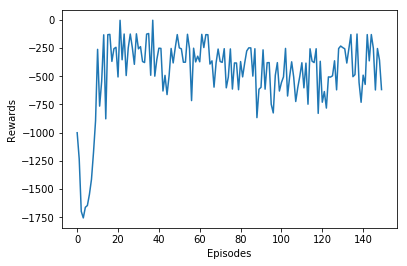

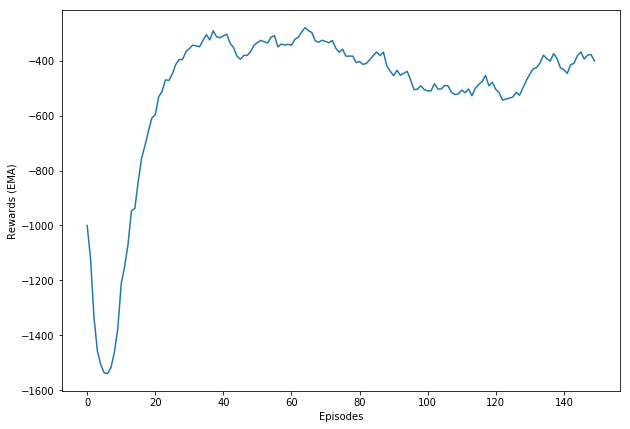

In [14]:
rewards_train_fromp = {}
rewards_test_fromp = {}
rewards_train_fromp['earth1'] = []
mem_pts = Memory(capacity = 512, n_tasks = 1)

# earth_id = np.array([1.0], dtype = np.float32)
# moon_id = np.array([2.0], dtype = np.float32)
# mars_id = np.array([3.0], dtype = np.float32)
# sun_id = np.array([4.0], dtype = np.float32)
# jupiter_id = np.array([5.0], dtype = np.float32)

replay_buffer_size = 10000
replay_buffer_earth = ReplayBuffer(replay_buffer_size)
torch.manual_seed(24)
pb_earth = torch.rand(pb_dim).to(device)
pb_earth.requires_grad_()
pb_moon = torch.rand(pb_dim).to(device)
pb_moon.requires_grad_()
pb_mars = torch.rand(pb_dim).to(device)
pb_mars.requires_grad_()
pb_sun = torch.rand(pb_dim).to(device)
pb_sun.requires_grad_()
pb_jupiter = torch.rand(pb_dim).to(device)
pb_jupiter.requires_grad_()
# pb_optim_earth = optim.Adam([pb_earth], lr=pb_lr)
pb_optim_earth = optim.SGD([pb_earth], lr=pb_lr, momentum = 0.99)
print(pb_earth)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
#     if ep >= 150:
#         pb_earth.detach_()
#         print(pb_earth)
    state = earth.reset()
    
#     state = np.concatenate((state, earth_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_earth.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        action = noise.get_action(action, t)
        next_state, reward, done, _ = earth.step(action)
#         next_state = np.concatenate((next_state, earth_OHE))
        replay_buffer_earth.push(state, action, reward, next_state, done)
        if len(replay_buffer_earth) > batch_size:
            fromp_update(t, batch_size, replay_buffer_earth, True, mem_pts, pb_earth, pb_optim_earth)
        
        state = next_state
        ep_reward += reward
        if done:
            break

    rewards_train_fromp['earth1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Earth Complete')
print(pb_earth)
rewards_earth1 = rewards_train_fromp['earth1']
plot_rewards(rewards_earth1)
plot_smoothed(rewards_earth1, 0.1)

In [15]:
# # Save video of earth agent
# frames = []
# actions_earth = {}
# for i in range(3):
# #     if i == 0:
# #         actions_earth[i] = []
# #     earth.reset()
# #     earth.state[:]= math.pi, 0
#     state = earth.reset()
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
#     state = np.concatenate((state, earth_OHE))
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(earth.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = earth.step(action)
#         next_state = np.concatenate((next_state, earth_OHE))
#         state = next_state
# #         if i == 0:
# #             actions_earth[i].append(action[0])
#         if done:
#             break
# earth.close()
# save_frames_as_gif(frames, filename='earth_train_animation_fromp_OHE.gif')

## Moon (FROMP)

tensor([0.5308, 0.9660, 0.2770], requires_grad=True)
Episode:  0
Episode:  100
Moon Complete
tensor([-357.5045,  -57.7537,  126.0190])


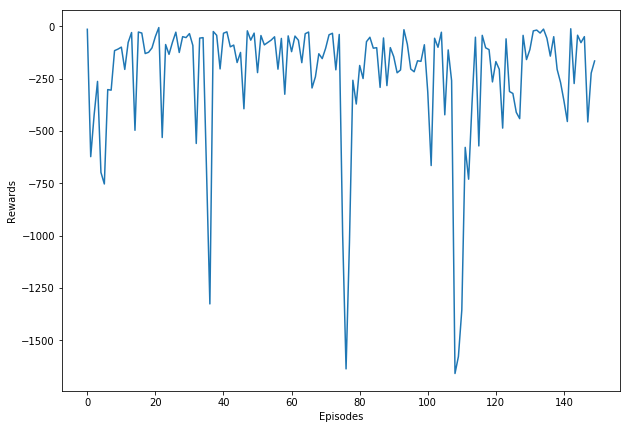

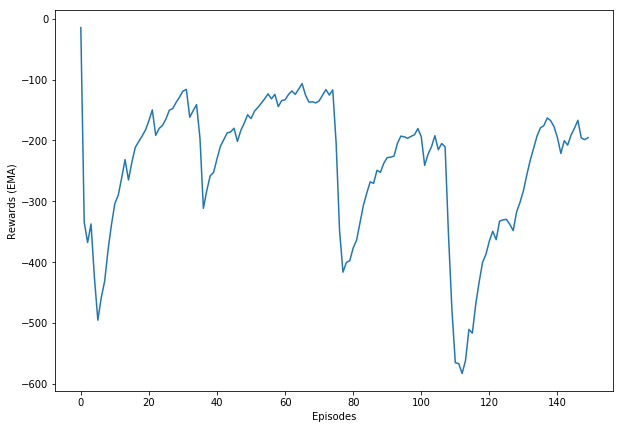

In [ ]:
rewards_train_fromp['moon1'] = []
mem_pts.add_task(2)

moon = NormalizedActions(gym.make('Pendulum-v1', g = 1.62))
moon.reset(seed = 24)

replay_buffer_moon = ReplayBuffer(replay_buffer_size)
# pb_optim_moon = optim.Adam([pb_moon], lr=pb_lr)
pb_optim_moon = optim.SGD([pb_moon], lr=pb_lr, momentum = 0.99)
print(pb_moon)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
#     if ep >= 150:
#         pb_moon.detach_()
#         print(pb_moon)
    state = moon.reset()
#     state = np.concatenate((state, moon_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_moon.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        action = noise.get_action(action, t)
        next_state, reward, done, _ = moon.step(action)
#         next_state = np.concatenate((next_state, moon_OHE))
        replay_buffer_moon.push(state, action, reward, next_state, done)
        if len(replay_buffer_moon) > batch_size:
            fromp_update(t, batch_size, replay_buffer_moon, False, mem_pts, pb_moon, pb_optim_moon, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['moon1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Moon Complete')
pb_moon.detach_()
print(pb_moon)
rewards_moon1 = rewards_train_fromp['moon1']
plot_rewards(rewards_moon1)
plot_smoothed(rewards_moon1, 0.1)

In [16]:
# # Save video of moon agent
# actions_moon = {}
# frames = []
# for i in range(3):
# #     if i == 0:
# #         actions_moon[i] = []
#     state = moon.reset()
# #     moon.state[:]= math.pi, 0
# #     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
#     state = np.concatenate((state, moon_OHE))
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(moon.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = moon.step(action)
#         next_state = np.concatenate((next_state, moon_OHE))
#         state = next_state
# #         if i == 0:
# #             actions_moon[i].append(action[0])
#         if done:
#             break
# moon.close()
# save_frames_as_gif(frames, filename='moon_train_animation_fromp_OHE.gif')

## Mars (FROMP)

In [ ]:
rewards_train_fromp['mars1'] = []
mem_pts.add_task(3)

mars = NormalizedActions(gym.make('Pendulum-v1', g = 3.71))
mars.reset(seed = 24)

replay_buffer_mars = ReplayBuffer(replay_buffer_size)
# pb_optim_mars = optim.Adam([pb_mars], lr=pb_lr)
pb_optim_mars = optim.SGD([pb_mars], lr=pb_lr, momentum = 0.99)
print(pb_mars)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
#     if ep >= 150:
#         pb_mars.detach_()
#         print(pb_mars)
    state = mars.reset()
#     state = np.concatenate((state, mars_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_mars.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        action = noise.get_action(action, t)
        next_state, reward, done, _ = mars.step(action)
#         next_state = np.concatenate((next_state, mars_OHE))
        replay_buffer_mars.push(state, action, reward, next_state, done)
        if len(replay_buffer_mars) > batch_size:
            fromp_update(t, batch_size, replay_buffer_mars, False, mem_pts, pb_mars, pb_optim_mars, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['mars1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Mars Complete')
pb_mars.detach_()
print(pb_mars)
rewards_mars1 = rewards_train_fromp['mars1']
plot_rewards(rewards_mars1)
plot_smoothed(rewards_mars1, 0.1)

tensor([0.3372, 0.8910, 0.4304], requires_grad=True)
Episode:  0
Episode:  100


In [18]:
# # Save video of mars agent
# actions_mars = {}
# frames = []
# for i in range(3):
# #     if i == 0:
# #         actions_mars[i] = []
#     state = mars.reset()
# #     mars.state[:]= math.pi, 0
# #     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
#     state = np.concatenate((state, mars_OHE))
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(mars.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = mars.step(action)
#         next_state = np.concatenate((next_state, mars_OHE))
#         state = next_state
#         if i == 0:
#             actions_mars[i].append(action[0])
#         if done:
#             break
# mars.close()
# save_frames_as_gif(frames, filename='mars_train_animation_fromp_OHE.gif')

## Sun (FROMP)

In [ ]:
rewards_train_fromp['sun1'] = []
mem_pts.add_task(4)

sun = NormalizedActions(gym.make('Pendulum-v1', g = 275))
sun.reset(seed = 24)

replay_buffer_sun = ReplayBuffer(replay_buffer_size)
# pb_optim_sun = optim.Adam([pb_sun], lr=pb_lr)
pb_optim_sun = optim.SGD([pb_sun], lr=pb_lr, momentum = 0.99)
print(pb_sun)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
#     if ep >= 150:
#         pb_sun.detach_()
#         print(pb_sun)
    state = sun.reset()
#     state = np.concatenate((state, sun_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_sun.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        action = noise.get_action(action, t)
        next_state, reward, done, _ = sun.step(action)
#         next_state = np.concatenate((next_state, sun_OHE))
        replay_buffer_sun.push(state, action, reward, next_state, done)
        if len(replay_buffer_sun) > batch_size:
            fromp_update(t, batch_size, replay_buffer_sun, False, mem_pts, pb_sun, pb_optim_sun, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['sun1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Sun Complete')
pb_sun.detach_()
print(pb_sun)
rewards_sun1 = rewards_train_fromp['sun1']
plot_rewards(rewards_sun1)
plot_smoothed(rewards_sun1, 0.1)

In [20]:
# # Save video of sun agent
# frames = []
# for _ in range(5):
#     state = sun.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(sun.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = sun.step(action)        
#         state = next_state
#         if done:
#             break
# sun.close()
# save_frames_as_gif(frames, filename='sun_train_animation_fromp.gif')

## Jupiter (FROMP)

In [ ]:
rewards_train_fromp['jupiter1'] = []
mem_pts.add_task(5)

jupiter = NormalizedActions(gym.make('Pendulum-v1', g = 24.5))
jupiter.reset(seed = 24)

replay_buffer_jupiter = ReplayBuffer(replay_buffer_size)
# pb_optim_jupiter = optim.Adam([pb_jupiter], lr=pb_lr)
pb_optim_jupiter = optim.SGD([pb_jupiter], lr=pb_lr, momentum = 0.99)
print(pb_jupiter)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
#     if ep >= 150:
#         pb_jupiter.detach_()
#         print(pb_jupiter)
    state = jupiter.reset()
#     state = np.concatenate((state, jupiter_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_jupiter.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        action = noise.get_action(action, t)
        next_state, reward, done, _ = jupiter.step(action)
#         next_state = np.concatenate((next_state, jupiter_OHE))
        replay_buffer_jupiter.push(state, action, reward, next_state, done)
        if len(replay_buffer_jupiter) > batch_size:
            fromp_update(t, batch_size, replay_buffer_jupiter, False, mem_pts, pb_jupiter, pb_optim_jupiter, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['jupiter1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Jupiter Complete')
pb_jupiter.detach_()
print(pb_jupiter)
rewards_jupiter1 = rewards_train_fromp['jupiter1']
plot_rewards(rewards_jupiter1)
plot_smoothed(rewards_jupiter1, 0.1)

In [ ]:
# # Save video of jupiter agent
# frames = []
# for _ in range(5):
#     state = jupiter.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(jupiter.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = jupiter.step(action)        
#         state = next_state
#         if done:
#             break
# jupiter.close()
# save_frames_as_gif(frames, filename='jupiter_train_animation_fromp.gif')

## Save and Plot Results

In [ ]:
train_df_fromp = pd.DataFrame(rewards_train_fromp)
train_df_fromp.to_csv('./Data/train_rewards_pendulum_fromp_PB.csv')
figure, axis = plt.subplots(1, 1)

axis.plot(train_df_fromp.ewm(alpha = 0.1).mean())
axis.set_xlabel("Episodes")
axis.set_ylabel("(Average) Reward")
axis.legend(['Earth', "Moon", "Mars", "Sun", "Jupiter"])
# axis.set_ylim(-1100, 0)
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.savefig("./Visualizations/train_no_CL_fromp_PB.jpg")
plt.show()

## Earth (test)

In [ ]:
rewards_test_fromp['earth'] = []
test_eps = 50
thetas = []
theta_dt = []
actions = []
print(pb_earth)

for ep in range(test_eps):
    state = earth.reset()
#     state = np.concatenate((state, earth_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_earth.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        next_state, reward, done, _ = earth.step(action)
#         next_state = np.concatenate((next_state, earth_OHE))
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['earth'].append(ep_reward)

print('Earth Complete')
rewards_earth = rewards_test_fromp['earth']
plot_rewards(rewards_earth)
plot_smoothed(rewards_earth, 0.1)

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Earth PB (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/earth_test_policy_fromp_PB.jpg")
plt.show()

In [ ]:
# # Save video of earth agent
# actions_earth_test = {}
# frames = []
# for i in range(3):
#     earth.reset()
#     earth.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
#     state = np.concatenate((state, earth_OHE))
#     if i == 0:
#         actions_earth_test[i] = []
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(earth.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = earth.step(action) 
#         next_state = np.concatenate((next_state, earth_OHE))
#         state = next_state
#         if i == 0:
#             actions_earth_test[i].append(action[0])
#         if done:
#             break
# earth.close()
# save_frames_as_gif(frames, filename='earth_test_animation_fromp_OHE.gif')

## Moon (test)

In [ ]:
rewards_test_fromp['moon'] = []
thetas = []
theta_dt = []
actions = []

for ep in range(test_eps):
    state = moon.reset()
#     state = np.concatenate((state, moon_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_moon.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        next_state, reward, done, _ = moon.step(action)
#         next_state = np.concatenate((next_state, moon_OHE))
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['moon'].append(ep_reward)

print('Moon Complete')
rewards_moon = rewards_test_fromp['moon']
plot_rewards(rewards_moon)
plot_smoothed(rewards_moon, 0.1)

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Moon PB (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/moon_test_policy_fromp_PB.jpg")
plt.show()

In [ ]:
# # Save video of moon agent
# actions_moon_test = {}
# frames = []
# for i in range(3):
#     if i == 0:
#         actions_moon_test[i] = []
#     moon.reset()
#     moon.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0] 
# #     state = np.concatenate((state, moon_OHE))
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(moon.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = moon.step(action)
# #         next_state = np.concatenate((next_state, moon_OHE))
#         state = next_state
#         if i == 0:
#             actions_moon_test[i].append(action[0])
#         if done:
#             break
# moon.close()
# save_frames_as_gif(frames, filename='moon_test_animation_fromp_OHE.gif')

## Mars (test)

In [ ]:
rewards_test_fromp['mars'] = []
thetas = []
theta_dt = []
actions = []

for ep in range(test_eps):
    state = mars.reset()
#     state = np.concatenate((state, mars_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_mars.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        next_state, reward, done, _ = mars.step(action)
#         next_state = np.concatenate((next_state, mars_OHE))
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['mars'].append(ep_reward)

print('Mars Complete')
rewards_mars = rewards_test_fromp['mars']
plot_rewards(rewards_mars)
plot_smoothed(rewards_mars, 0.1)

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Mars PB (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/mars_test_policy_fromp_PB.jpg")
plt.show()

In [ ]:
# # Save video of mars agent
# actions_mars_test = {}
# frames = []
# for i in range(3):
#     if i == 0:
#         actions_mars_test[i] = []
#     mars.reset()
#     mars.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0] 
# #     state = np.concatenate((state, mars_OHE))
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(mars.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = mars.step(action) 
# #         next_state = np.concatenate((next_state, mars_OHE))
#         state = next_state
#         if i == 0:
#             actions_mars_test[i].append(action[0])
#         if done:
#             break
# mars.close()
# save_frames_as_gif(frames, filename='mars_test_animation_fromp_OHE.gif')

## Sun (test)

In [ ]:
rewards_test_fromp['sun'] = []

for ep in range(test_eps):
    state = sun.reset()
#     state = np.concatenate((state, sun_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_sun.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        next_state, reward, done, _ = sun.step(action)
#         next_state = np.concatenate((next_state, sun_OHE))
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['sun'].append(ep_reward)

print('Sun Complete')
rewards_sun = rewards_test_fromp['sun']
plot_rewards(rewards_sun)
plot_smoothed(rewards_sun, 0.1)

In [ ]:
# # Save video of sun agent
# frames = []
# for _ in range(5):
#     state = sun.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(sun.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = sun.step(action)        
#         state = next_state
#         if done:
#             break
# sun.close()
# save_frames_as_gif(frames, filename='sun_test_animation_fromp.gif')

## Jupiter (test)

In [ ]:
rewards_test_fromp['jupiter'] = []

for ep in range(test_eps):
    state = jupiter.reset()
#     state = np.concatenate((state, jupiter_OHE))
    ep_reward = 0
    for t in range(max_steps):
        temp_pb = pb_jupiter.detach().numpy().copy()
        action = policy_net_fromp.get_action(np.concatenate((state, temp_pb)))
        next_state, reward, done, _ = jupiter.step(action)
#         next_state = np.concatenate((next_state, jupiter_OHE))
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['jupiter'].append(ep_reward)

print('Jupiter Complete')
rewards_jupiter = rewards_test_fromp['jupiter']
plot_rewards(rewards_jupiter)
plot_smoothed(rewards_jupiter, 0.1)

In [ ]:
# # Save video of jupiter agent
# frames = []
# for _ in range(5):
#     state = jupiter.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(jupiter.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = jupiter.step(action)        
#         state = next_state
#         if done:
#             break
# jupiter.close()
# save_frames_as_gif(frames, filename='jupiter_test_animation_fromp.gif')

## Save Test Results

In [ ]:
test_df_fromp = pd.DataFrame(rewards_test_fromp)
test_df_fromp.to_csv('./Data/test_rewards_pendulum_fromp_PB.csv')
print("****TRAINING RESULTS (FROMP PB)****")
print(train_df_fromp.tail(50).mean())
print("****TEST RESULTS (FROMP PB)****")
print(test_df_fromp.mean())

In [37]:
def plot_actions(actions1, actions2, names,
                 n_tail = 50, col = ['blue', 'red'], filename = "./Visualizations/trajectory.jpg", title = None):
    x_vals = np.arange(n_tail)
    actions1 = actions1[-n_tail:]
    actions2 = actions2[-n_tail:]
    plt.plot(x_vals, actions1, '-', color = col[0])
    plt.plot(x_vals, actions2, '-', color = col[1])
    plt.legend(names)
    plt.xlabel("Step")
    plt.ylabel("Action")
    if title is not None:
        plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(16, 12)
    plt.savefig(filename)
    plt.show()

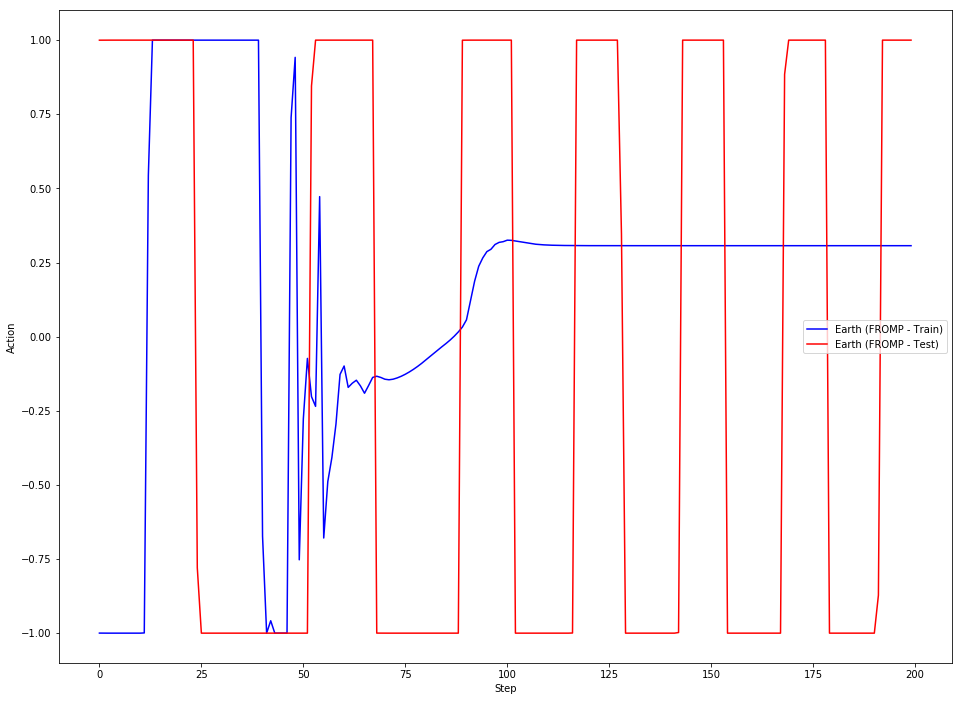

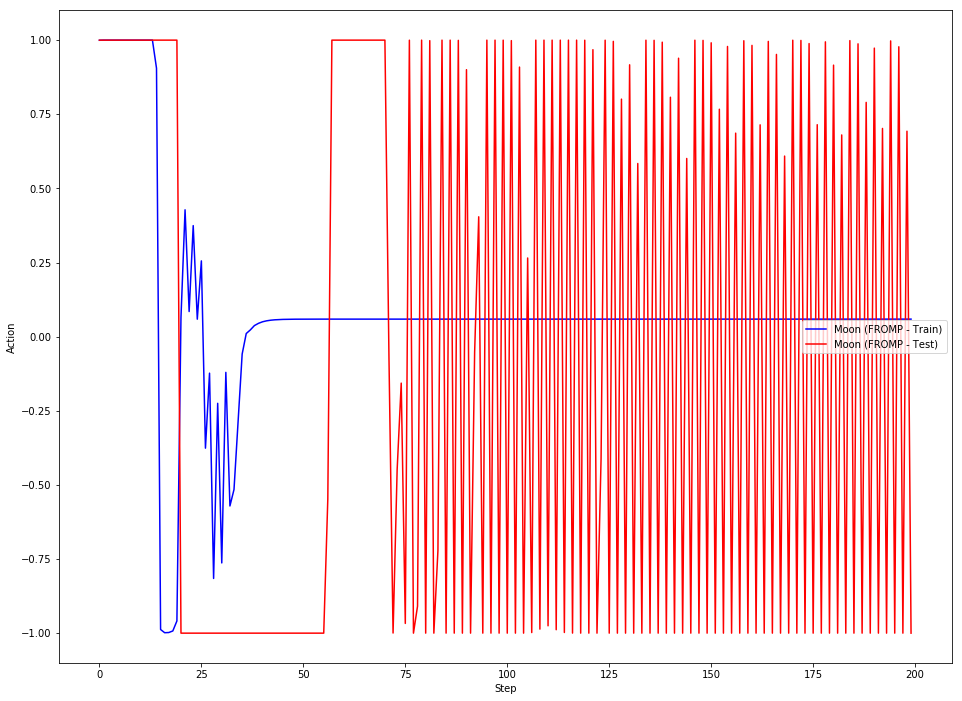

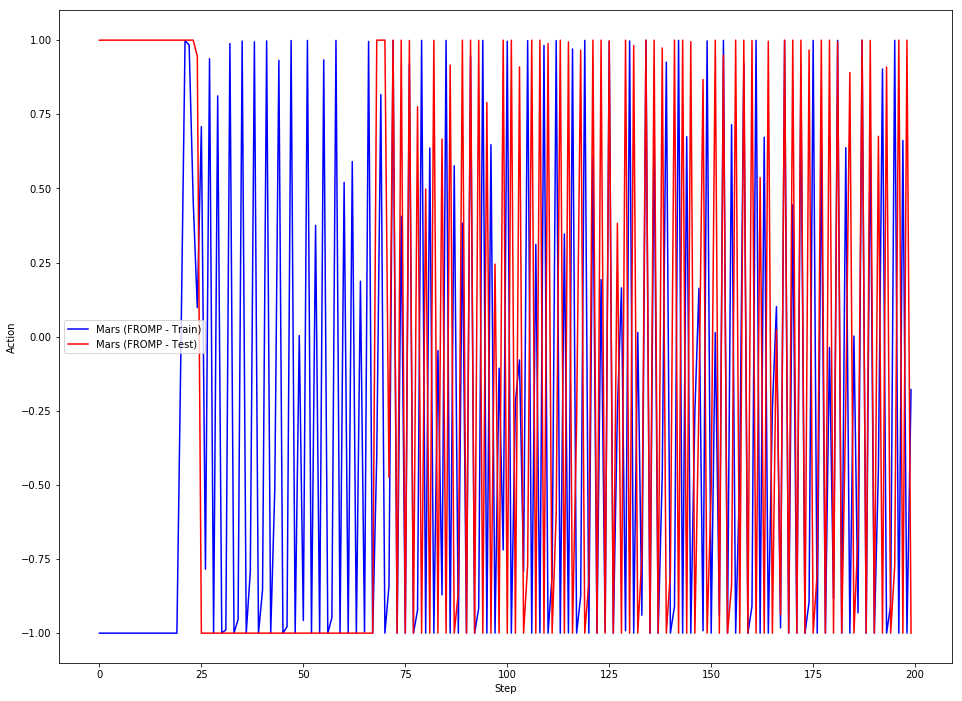

In [38]:
plot_actions(actions_earth[0], actions_earth_test[0], ['Earth (FROMP - Train)', 'Earth (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_earth_test_fromp_OHE.jpg")
plot_actions(actions_moon[0], actions_moon_test[0], ['Moon (FROMP - Train)', 'Moon (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_moon_test_fromp_OHE.jpg")
plot_actions(actions_mars[0], actions_mars_test[0], ['Mars (FROMP - Train)', 'Mars (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_mars_test_fromp_OHE.jpg")

## Visualize Results

In [109]:
# earth = NormalizedActions(gym.make('Pendulum-v1', g = 9.81, render_mode = 'human'))
# earth.reset(seed = 24)

# for _ in range(5):
#     state, info = earth.reset(return_info=True)
#     for t in range(max_steps):
#         action = policy_net_fromp.get_action(state)
#         next_state, reward, done, _ = earth.step(action)   
#         state = next_state       
#         if done:
#             state, info = earth.reset(return_info=True)
#             break
# #         earth.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# earth.close()

Complete


In [149]:
# for _ in range(5):
#     state = moon.reset()
#     state = np.concatenate((state, moon_OHE))
#     for t in range(max_steps):
#         action = policy_net.get_action(state)
#         next_state, reward, done, _ = moon.step(action)   
#         next_state = np.concatenate((next_state, moon_OHE))
#         state = next_state       
#         if done:
#             break
#         moon.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# moon.close()

In [150]:
# for _ in range(5):
#     state = mars.reset()
#     for t in range(max_steps):
#         action = policy_net.get_action(state)
#         next_state, reward, done, _ = mars.step(action)   
#         state = next_state       
#         if done:
#             break
#         mars.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# mars.close()